In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import colossus
import colossus.cosmology
import colossus.cosmology.cosmology as cosmology
import colossus.halo
import colossus.halo.mass_so as halo_mass
import colossus.halo.concentration as halo_concentration

#from colossus.cosmology import cosmology
#from colossus.halo.mass_so import M_to_R
#from colossus.halo.concentration import concentration

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Random gaussian field creation

## Code

In [2]:
map_size = 2 #arcminutes
pixel_size = 1/2 #arcseconds

pixel_number = map_size*(60/pixel_size)

x = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
y = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

l = np.arange(30000, dtype=float)
const = 10
index = -0.7

spectrum=const*(l**index)
spectrum[0] = 0

/tmp/ipykernel_12563/319828132.py:15: RuntimeWarning: divide by zero encountered in power
  spectrum=const*(l**index)


In [3]:
fs_scale_factor = np.pi/(pixel_size/60 * np.pi/180)
R_fs = R*fs_scale_factor
print(R_fs.astype(int))

spectrum_map = np.zeros(int(R_fs.max())+1)

spectrum_map[0:spectrum.size] = spectrum

spectrum_map_confined = spectrum_map[(R_fs).astype(int)]
print(spectrum_map.shape)
print(spectrum_map_confined.shape)
print(240*240)

[[30547 30419 30292 ... 30292 30419 30547]
 [30419 30291 30163 ... 30163 30291 30419]
 [30292 30163 30035 ... 30035 30163 30292]
 ...
 [30292 30163 30035 ... 30035 30163 30292]
 [30419 30291 30163 ... 30163 30291 30419]
 [30547 30419 30292 ... 30292 30419 30547]]
(30548,)
(240, 240)
57600


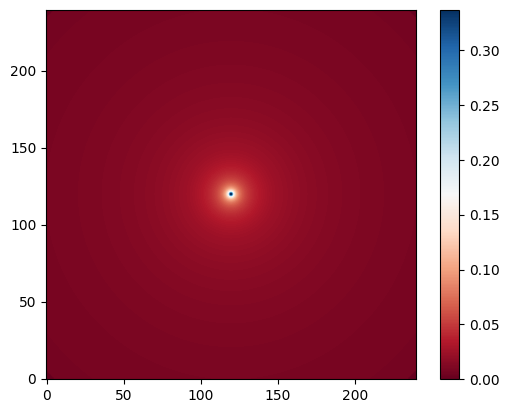

In [4]:
im = plt.imshow(spectrum_map_confined, interpolation='bilinear', origin='lower', cmap='RdBu')
#im.set_clim(0,spectrum_map_confined.max()/4)
cbar = plt.colorbar()
plt.show()

In [5]:
random_noise_2d = np.random.normal(0, 1, (int(pixel_number), int(pixel_number)))
random_noise_2d_fs = np.fft.fft2(random_noise_2d)

signal_map_fs = spectrum_map_confined*random_noise_2d_fs

signal_map = np.fft.ifft2(np.fft.fftshift(signal_map_fs))

In [6]:
#signal_map = np.fft.ifft2(signal_map_fs)
signal_map = signal_map / fs_scale_factor
signal_map = np.real(signal_map)

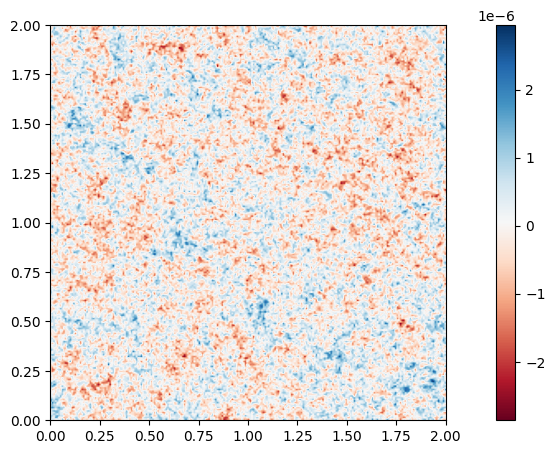

In [83]:
im = plt.imshow(signal_map, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim()
X_width = pixel_number*pixel_size/60.  # horizontal map width in degrees
Y_width = pixel_number*pixel_size/60.  # vertical map width in degrees

plt.gcf().set_size_inches(6,6)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.show()

In [72]:
signal_map.max()

np.float64(2.9528164047595824e-06)

## Class

In [2]:
class missing_variable_error(Exception):
    """raised when necessary variables are not given"""
    def __init__(self, variable_name: str):
        super().__init__(f"{variable_name} has not been specified. Please provide a value.")

class map_maker():
    def __init__(self, map_size: int = None, pixel_size: float = None, pixel_number: int = None, l_degrees: int = None, const: float = 1, index: float = -1):
        ## external variables
        self.map_size = map_size
        self.pixel_size = pixel_size
        self.pixel_number = pixel_number
        self.l_degrees = l_degrees
        self.const = const
        self.index = index
        ## internal variables
        self.spectrum = None                       # unless loaded in
        self.R = None
        self.R_check = False
        self.fs_scale_factor = None
        self.R_fs = None
        self.R_fs_check = False
        self.random_noise_2d = None
        self.random_noise_2d_fs = None
        ## output variables
        self.grf_fs = None
        self.grf = None
        self.rms = None

    def set_map_variables(self, map_size = None, pixel_size = None, pixel_number = None) -> bool:
        if map_size is not None:
            self.map_size = map_size
        if pixel_size is not None:
            self.pixel_size = pixel_size
        if pixel_number is not None:
            self.pixel_number = pixel_number
        else:
            self.pixel_number = self.map_size*(60/self.pixel_size)
        if not all((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing map_variables.")
            return False
        else:
            print("Full set of map variables defined.")
            return True

    def make_map_coordinates(self, map_size = None, pixel_size = None, pixel_number = None):
        
        if any((map_size, pixel_size, pixel_number)) or self.pixel_number is None:
            self.set_map_variables(map_size, pixel_size, pixel_number)
        x = np.linspace(-0.5*self.map_size, 0.5*self.map_size, int(self.pixel_number))
        y = np.linspace(-0.5*self.map_size, 0.5*self.map_size, int(self.pixel_number))
        X, Y = np.meshgrid(x, y, sparse=True)           ## TODO: check if sparse works correctly
        self.R = np.sqrt(X**2 + Y**2)
        self.R_check = True
        print("map made.")

        return None
    
    def _compute_fourierSpace_scaler(self) -> float:
        if self.pixel_size is None:
            raise missing_variable_error("pixel_size")
        fs_scale_factor = np.pi/(self.pixel_size/60 * np.pi/180)
        self.fs_scale_factor = fs_scale_factor
        return fs_scale_factor
    
    def _R_fourierSpace_mapping(self) -> list[float]:
        scale = self._compute_fourierSpace_scaler()
        R_fs = self.R*scale
        self.R_fs = R_fs
        self.R_fs_check = True
        return R_fs
    
    def set_spectrum_variables(self, l_degrees: int = None, const:float = None, index: float = None) -> bool:
        if l_degrees is not None:
            print(l_degrees)
            self.l_degrees = l_degrees
            print(self.l_degrees)
        if const is not None:
            self.const = const
        if index is not None:
            self.index = index
        if not any((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing variables for the spectrum (power-law).")
            return False
        else:
            print("Full set of variables for the spectrum (power-law) defined.")
            return True

    def make_spectrum(self, const: float = None, l_degrees: int = None, index: float = None) -> None:
            
        self.set_spectrum_variables(const, l_degrees, index)
        l = np.arange(self.l_degrees, dtype=float)

        spectrum=self.const*(l**self.index)
        spectrum[0] = 0
        self.spectrum = spectrum

        return None
    
    def load_spectrum(self, path: str) -> None:
        """ 
            Spectrum different than a power law? Here you go...
            TODO: All of it ...
        """
        return None
    
    def make_spectrum_map(self, spectrum_path: str = None, const: float = None, l_degrees: int = None, index: float = None) -> None:
        """ 
            Creates a map of the spectrum (Inside Fourier Space) as well as a cut version leaving out areas of null values.
            TODO: add option to intervene in scale

        """

        if spectrum_path is not None:
            self.load_spectrum(self, spectrum_path)
        elif any((const, l_degrees, index)) or self.spectrum is None:
            self.make_spectrum(const, l_degrees, index)

        if self.R_fs is None:
            self._R_fourierSpace_mapping()

        spectrum_map_complete = np.zeros(int(self.R_fs.max())+1)
        spectrum_map_complete[0:self.spectrum.size] = self.spectrum

        if self.R_fs is None:
            raise missing_variable_error("R_fs")

        spectrum_map_confined = spectrum_map_complete[(self.R_fs).astype(int)]
        self.spectrum_map_complete = spectrum_map_complete
        self.spectrum_map_confined = spectrum_map_confined
        return None

    def _make_random_noise(self, N: int = None) -> None:
        if N is not None:
            self.pixel_number = N
        self.random_noise_2d = np.random.normal(0, 1, (int(self.pixel_number), int(self.pixel_number)))
        self.random_noise_2d_fs = np.fft.fft2(self.random_noise_2d)
        return None

    def make_gaussian_random_field(self) -> list[float]:
        
        if not self.R_check:
            self.make_map_coordinates()
        if not self.R_fs_check:  
            self._R_fourierSpace_mapping()
        self.make_spectrum_map()
        self._make_random_noise()

        self.grf_fs = self.spectrum_map_confined*self.random_noise_2d_fs              ## gaussian-random-field in Fourier-Space

        self.grf = np.fft.ifft2(np.fft.fftshift(self.grf_fs))           ## gaussian-random-field after inverse fft2

        self.grf_real = np.real(np.fft.ifft2(np.fft.fftshift(self.grf_fs))) 
        
        return self.grf_fs, self.grf, self.grf_real
    
    def plot_gaussian_random_field(self) -> None:
        im = plt.imshow(self.grf_real, origin='lower', interpolation='bilinear', cmap='RdBu')
        im.set_clim()

        plt.xlabel(r"$\theta_x$[arcmin]")
        plt.ylabel(r"$\theta_y$[arcmin]")

        cbar = plt.colorbar(im)
        cbar.set_label("T [K]")   # label for the scale
        return None
    
    def rms_estimation(self) -> float:
        self.rms = np.sqrt(np.mean(self.grf_real**2))
        return self.rms

## Test

Full set of map variables defined.
map made.
Full set of variables for the spectrum (power-law) defined.
3.5896274752241937e-07


/tmp/ipykernel_10019/2613377579.py:93: RuntimeWarning: divide by zero encountered in reciprocal
  spectrum=self.const*(l**self.index)


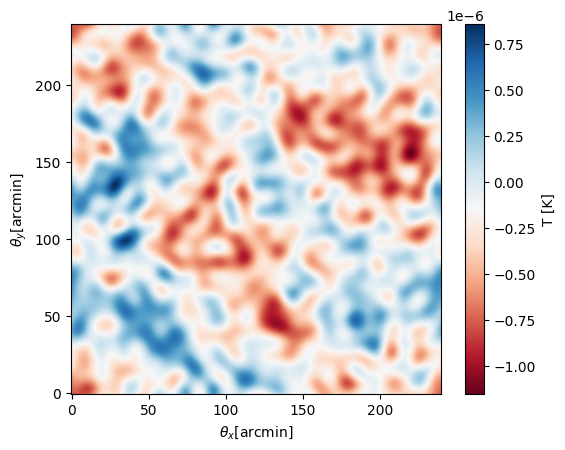

In [7]:
test1 = map_maker(map_size=2, pixel_size=0.5, l_degrees=3000, const=3e-3, index=-1)
test1_map_fs, test1_map, test1_map_real = test1.make_gaussian_random_field()
test1.plot_gaussian_random_field()
print(test1.rms_estimation())

# lens profile

## code

In [ ]:
# cluster parameters

cluster_mass = 5e14
cluster_redshift = 0.7
omega_m = 0.3089
omega_l = 0.6911
G = 4.30091 * 10**(-3) / (10**(6))

def scaler_expansion(omega_m, omega_l, a):
    return 1/np.sqrt(a * omega_m + a**4 * omega_l)


In [9]:
cosmology.setCosmology("planck18")

def calc_comoving_dist(z, H_zero, omega_m, omega_l):
    return (c * H_zero) * integrate.quad(scaler_expansion(), np.power(1+z, -1), 1, args = (omega_m, omega_l))[0]


def r_x(m, z, h):
    """
        h = scaled Hubble
    """
    return halo_mass.M_to_R(m, z, "200c") * h /10**3

def c_x(m, z):
    """ 
    
    """
    return halo_concentration.concentration(m, "200c", z, model = 'diemer15')

def calc_Hubble_parameter(z, H_zero):
    return np.sqrt( H_zero**2 * ((1+z)**3 * omega_m + omega_l ))

def calc_rho_crit(z):
    G = 4.30091 * 10**(-3) / (10**(6))
    return (3 * calc_Hubble_parameter(z)**2) / (8 * np.pi * G)

def density_parameter(m, z):
    c_200 = c_x(m, z)
    return (200/3) * calc_rho_crit(z)

def rho_NFW(r, M_200, z):
    """ 
        NFW Density profile in ((M_(solar))/(Mpc**(-3)))
        Input:  - r: float =        
                - M_200: float =    
                - z: float =        
        Return: 
    """
    # scale radius R_s [Mpc]
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    # density parameter 
    density_para = density_parameter(M_200, z)
    return density_para / ((r/R_s)*(1 + (r/R_s))**2)
 
def M_NFW(r, M_200, z):
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    return  4 * np.pi * density_parameter(M_200, z) * np.power(R_s, 3) * (np.log((R_s + r)/R_s) - (r/(R_s + r)))

In [10]:
rho_NFW(2, 2, 2)

np.float64(1.3551912813969275e-06)

In [11]:
M_NFW(2, 2, 2)

np.float64(0.0019292414150759913)

In [ ]:
def calc_lambda(angle, M_200, z):
    x_1 = calc_comov_dist(z)
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    return x_1 * angle / ((1+z) * R_s)

def calc_f(angle, m, z):
    lmb = calc_lambda(angle, m, z)

    f = n.zeros(np.shape(angle))
    for i in range(np.shape(f)[0]):
        for j in range(np.shape(f)[1]):
            if lmb[i][j] > 1:
                f[i][j] = (3.23 / lmb[i][j]) * (np.log(lmb[i][j]/2)) + np.log(lmb[i][j]/(1 - np.sqrt(1 - lmb[i][j]**2))) / np.sqrt(1 - lmb[i][j]**2)
            elif lmb[i][j] < 1:
                f[i][j] = (3.23 / lmb[i][j]) * (np.log(lmb[i][j]/2) + (np.pi/2 - np.arcsin(1/lmb[i][j]) ) / np.sqrt(lmb[i][j]**2 - 1) )
            else:
                print("lmb = " + str(lmb[i][j]) + "lmb will be calculated as if smaller than 1")
    return f

def calc_v_max(m, z):
    R_s = r_x(M_200, z, 1)/c_x(M_200, z)
    return 0.46 * np.sqrt(4 * np.pi * G * density_parameter * R_s**2)

def d_theta(r, m, z):
    theta = r/calc_comoving_dist(z, H_zero, omega_m, omega_l)
    return 0.54 * (calc_v_max(m, z))**2 * (calc_comoving_dist(z, H_zero, omega_m, omega_l) - calc_comoving_dist(1100.0, H_zero, omega_m, omega_l)) * (calc_f(theta, m, z) / calc_comoving_dist(1100.0, H_zero, omega_m, omega_l))


## class

In [ ]:
class lens_profile():
    """ 
        class is mostly reused/cleaned code from Awais Mirza 2019 at Argelander Institut Bonn
    """
    def __init__(self, cluster_mass = 5e14, cluster_redshift = 0.7, hubble_constant = 67.74, cosmology = "planck18", omega_m = 0.3089, omega_l = 0.6911, grav_constant = 4.30091 * 10**(-3) / (10**(6)), speed_of_light = scipy.constants.speed_of_light):
        ## cluster parameters
        self.M = cluster_mass
        self.z = cluster_redshift
        ## physics
        self.c = speed_of_light
        self.cosmology = cosmology
        self.omega_m = omega_m
        self.omega_l = omega_l
        self.h_zero = hubble_constant/100 ## automatically scaled
        ## internal parameters
        self.hubble_parameter_factor = None
        self.hubble_parameter = None
        self.comoving_dist = None
        self.r_x = None

        print("cluster mass " + str(self.M) +"\n"
                + "cluster redshift z:" + str(self.z) + "\n"
                + "speed of light:" + str(self.c) + "\n"
                + "scaled hubble constant:" + str(self.h) + "\n"
                + "omega_m:" + str(self.omega_m) + "\n"
                + "omega_l:" + str(self.omega_l) + "\n"
                + "cosmology" + str(self.cosmology))
    
    def _calc_hubble_parameter_factor(self, omega_m: float = None, omega_l: float = None, z: float = None) -> float:
        if omega_m:
            self.omega_m = omega_m
            print("omega_m changed to: " + str(omega_m))
        if omega_l:
            self.omega_l = omega_l
            print("omega_l changed to: " + str(omega_l))
        if z:
            self.z = z
            print("redshift z changed to: " + str(z))
        self.hubble_parameter_factor = 1/np.sqrt((1+self.z) * self.omega_m + (1+self.z)**4 * self.omega_l)
        #print("Hubble parameter factor is set to: " + str(self.hubble_parameter_factor))
        return self.hubble_parameter_factor

    def _calc_hubble_parameter(self, h_zero: float = None) -> float:
        if h_zero:
            self.h_zero = h_zero
            print("h_zero changed to: " + str(h_zero))
        if any([omega_m: float = None, omega_l: float = None, z: float = None]):
            self._calc_hubble_parameter_factor(omega_m: float = None, omega_l: float = None, z: float = None)

        self.hubble_parameter = np.sqrt(self.h_zero**2 * self.hubble_parameter_factor)
        print("hubble parameter = " + str(self.hubble_parameter))
        return self.hubble_parameter

    def _calc_comoving_dist(self, c: float = None, h_zero: float = None, omega_m: float = None, omega_l: float = None, z: float = None) -> float:
        if h_zero:
            self.h_zero = h_zero
            print("h_zero changed to: " + str(h_zero))
        if c:
            self.c = c
            print("speed of light c changed to: " + str(c))
        if any([omega_m: float = None, omega_l: float = None, z: float = None]):
            self._calc_hubble_parameter_factor(omega_m: float = None, omega_l: float = None, z: float = None)
        
        self.comoving_dist = (self.c * self.h_zero) * integrate.quad(self.hubble_parameter, np.power(1+self.z, -1), 1, args = (self.omega_m, self.omega_l))[0]
        print("comoving_dist = " + str(self.comoving_dist))
    return self.comoving_dist

    def _calc_r_x(self, option_flag: str = "200c") -> float:
    """

    """
    self.r_x = halo_mass.M_to_R(self.M, self.z, option_flag) * self.hubble_parameter /10**3 #!!!!!!!!!!!!!11Using self.hubble_parameter instead of self.h_zero. Is that correct???
    print("r_x = " + str(self.r_x))
    return self.r_x

    def _calc_c_x()
        


# lensing

## code

In [39]:
class lensing():
    def __init__(self, map_size: float = None, pixel_size: float = None, pixel_number: int = None, dec_shift = 0, asc_shift = 0, pre_lens_map: list[list[float]] = None, poly_degree = 2):
        self.map_size = map_size
        self.pixel_size = pixel_size
        self.pixel_number = pixel_number
        self.dec_shift = dec_shift
        self.asc_shift = asc_shift
        self.pre_lens_map = pre_lens_map
        self.l_total = poly_degree
        ## internal vatiables
        self.pos_map = None
        self.pos_map_fs = None
        self.lensing_map = None
        ## output
        self.post_lensing_map = None

    
    def set_NFW_variables(self) -> None:
        return None
    
    def make_NFW_profile(self) -> None:
        return None
    
    def set_map_parameters(self, map_size: float = None, pixel_size: float = None, pixel_number: int = None) -> None:
        if map_size is not None:
            self.map_size = map_size
        if pixel_size is not None:
            self.pixel_size = pixel_size
        if pixel_number is not None:
            self.pixel_number = pixel_number
        else:
            self.pixel_number = self.map_size*(60/self.pixel_size)
        if not all((self.map_size, self.pixel_size, self.pixel_number)):
            print("!!!!!!!!!!!There are still missing map_variables.")
            return False
        else:
            print("Full set of map variables defined.")
            return True
    
    def make_lensing_map():
        return None
    
    def set_pre_lens_map(self, map: list[list[float]]) -> None:
        self.pre_lens_map = map
        return None
    
    def copy_map_parameters(self):
        if not (self.pre_lens_map).any():
            print("!!!!!!!!!!!!!!!!! Please first provide a pre lens map.")
        elif ((self.pre_lens_map).shape[0] != (self.pre_lens_map).shape[1]):
            print("!!!!!!!!!!Please provide squared map.")
        else:
            self.pixel_number = (self.pre_lens_map).shape[0]
            self.pixel_size = 1                                     ######### Temporary solution
            self.map_size = self.pixel_number                       ######### Temporary solution
            print("Map parameters: map_size = " + str(self.map_size) + ", pixel_size = " + str(self.pixel_size) + ", pixel_number = " + str(self.pixel_number) + ".")
        return None
    
    # def _make_background_map(self) -> list[list[list[float]], float]:
    #     mean = np.mean(self.pre_lens_map)
    #     bg_map = np.ones((self.pixel_number, self.pixel_number))*mean
    #     self.background_map = bg_map
    #     return bg_map, mean
    
    def _make_pos_map(self, shift_dec = 0, shift_asc = 0):
        # real_space
        dec, asc = np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number), np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number)
        pos_map = np.meshgrid(dec, asc)
        ## Necessary because tuples can only be read (not modified)
        pos_map_obj_1, pos_map_obj_2 = pos_map 
        pos_map_obj_1 += shift_dec
        pos_map_obj_2 += shift_asc
        self.pos_map =  pos_map_obj_1, pos_map_obj_2

        # fourier_space
        x, y = 2*np.pi*np.fft.fftfreq(self.pixel_number, (np.pi*180)*self.pixel_size/60), 2*np.pi*np.fft.fftfreq(self.pixel_number, (np.pi*180)*self.pixel_size/60)  ## pixel_size given in seconds
        self.pos_map_fs = np.meshgrid(x, y)
        return None
    
    def _make_pos_map_test(self, shift_dec = 0, shift_asc = 0) -> None:
        # real_space
        dec, asc = np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number), np.linspace(-self.map_size/2, self.map_size/2, self.pixel_number)
        pos_map = np.meshgrid(dec, asc)
        ## Necessary because tuples can only be read (not modified)
        pos_map_obj_1, pos_map_obj_2 = pos_map 
        pos_map_obj_1 += shift_dec
        pos_map_obj_2 += shift_asc
        self.pos_map =  pos_map_obj_1, pos_map_obj_2

        # fourier_space
        self.pos_map_fs = np.fft.fft2(self.pos_map)

        return None
    
    def apply_lensing(self, pre_lens_map = None, shift_dec = 0, shift_asc = 0):
        if pre_lens_map:
            self.pre_lens_map = pre_lens_map

        self._make_pos_map(shift_dec, shift_asc)
        dec_pos, asc_pos = self.pos_map
        post_lensing_dec_pos, post_lensing_asc_pos = dec_pos + self.lensing_map[0], asc_pos + self.lensing_map[1]
        interpolate = scipy.interpolate.RectBivariateSpline(asc_pos[:,0], dec_pos[0,:], self.pre_lens_map, kx = self.l_total, ky = self.l_total)
        print(interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()))
        print(interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()).reshape([len(asc_pos), len(dec_pos)]))
        self.post_lensing_map  = interpolate.ev(post_lensing_asc_pos.flatten(), post_lensing_dec_pos.flatten()).reshape([len(asc_pos), len(dec_pos)]) 

        return None
    
    def get_lensed_map(self) -> list[list[float]]:
        return self.post_lensing_map
    
    def plot_lensed_map():
        return None

In [40]:
cmb = np.array([[0, 1, 1], [1, 1, 0], [2, 0, 1]])
cmb_lensing = np.array([[3, 0, -3], [3, 0, -3], [3, 0, -3]]), np.array([[3, 3, 3], [0, 0, 0], [-3, -3, -3]])

#cmb = np.array([[0, 0, 0, 1, 1], [0, 0, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])
#cmb_lensing = np.array([[5, 3, 0, -3, -5],[5, 3, 0, -3, -5], [5, 3, 0, -3, -5], [5, 3, 0, -3, -5], [5, 3, 0, -3, -5]]), np.array([[-5, -5, -5, -5, -5], [-3, -3, -3, -3, -3], [0, 0, 0, 0, 0], [3, 3, 3, 3, 3], [5, 5, 5, 5, 5]])*(-1)

#cmb = np.random.rand(101, 101)
#x_spiegel = np.linspace(-100, 100, 101)
#y_spiegel = np.linspace(-100, 100, 101)
#cmb_lensing = x_spiegel, y_spiegel




lensTest1 = lensing(pre_lens_map=cmb)
lensTest1.lensing_map = cmb_lensing

#lensTest1.set_map_parameters(10, 1, 10)
lensTest1.copy_map_parameters()

Map parameters: map_size = 3, pixel_size = 1, pixel_number = 3.


In [41]:
lensTest1._make_pos_map()
lensTest1.apply_lensing()
#lensTest1.get_lensed_map()

[1. 0. 2. 0. 1. 1. 1. 1. 0.]
[[1. 0. 2.]
 [0. 1. 1.]
 [1. 1. 0.]]


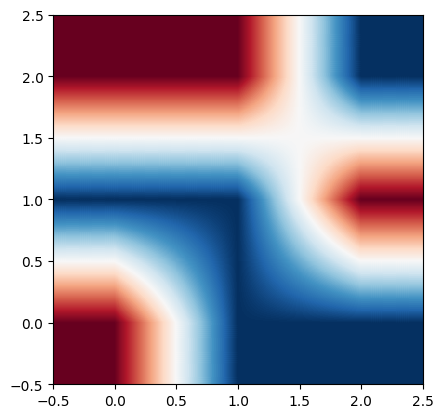

In [35]:
im2 = plt.imshow(cmb, origin='lower', interpolation='bilinear', cmap='RdBu')
im2.set_clim()

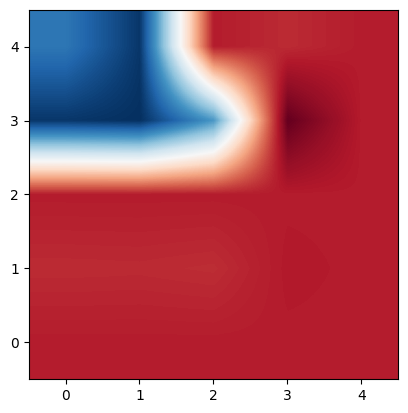

In [42]:
im2 = plt.imshow(lensTest1.get_lensed_map(), origin='lower', interpolation='bilinear', cmap='RdBu')
im2.set_clim()

In [25]:
x_spiegel = np.linspace(-100, 100, 101)
#x_spiegel[0:50] = x_spiegel[0:50]-1
y_spiegel = np.linspace(-100, 100, 101)
spiegel = np.meshgrid(x_spiegel, y_spiegel)
spiegel

(array([[-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        ...,
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.],
        [-100.,  -98.,  -96., ...,   96.,   98.,  100.]], shape=(101, 101)),
 array([[-100., -100., -100., ..., -100., -100., -100.],
        [ -98.,  -98.,  -98., ...,  -98.,  -98.,  -98.],
        [ -96.,  -96.,  -96., ...,  -96.,  -96.,  -96.],
        ...,
        [  96.,   96.,   96., ...,   96.,   96.,   96.],
        [  98.,   98.,   98., ...,   98.,   98.,   98.],
        [ 100.,  100.,  100., ...,  100.,  100.,  100.]], shape=(101, 101)))

In [8]:
cmb

array([[0.88209546, 0.58144781, 0.96147407, ..., 0.89275294, 0.20781482,
        0.16829575],
       [0.23936019, 0.68616057, 0.46952962, ..., 0.60284743, 0.80208226,
        0.10541345],
       [0.28077568, 0.43644544, 0.32167395, ..., 0.11679424, 0.37198256,
        0.08222438],
       ...,
       [0.78069873, 0.55273555, 0.44812325, ..., 0.47573144, 0.87367432,
        0.46137952],
       [0.823493  , 0.12594808, 0.05810748, ..., 0.28283685, 0.07433936,
        0.20595412],
       [0.83080826, 0.43798354, 0.78109664, ..., 0.14108825, 0.98697004,
        0.49385929]], shape=(100, 100))

## class

# Other

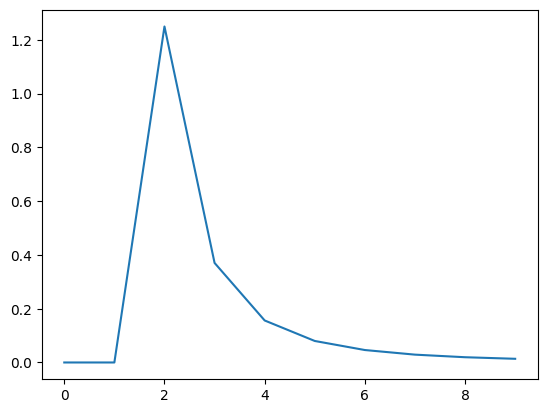

In [15]:
plt.plot(l, spectrum)

In [12]:
3**(-3)*10

0.37037037037037035

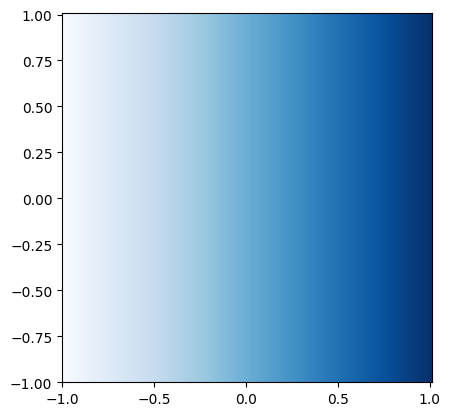

In [9]:
plt.imshow(X, cmap = 'Blues', extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])

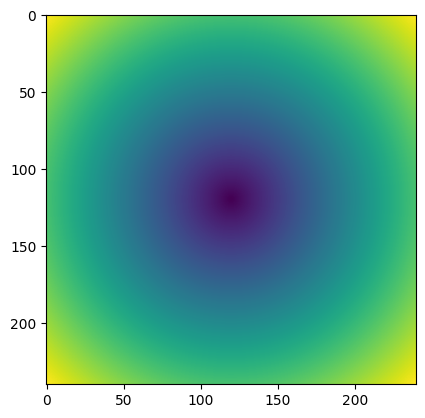

In [15]:
plt.imshow(R)

In [11]:
X

array([[-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       ...,
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ]])

In [13]:
Y

array([[-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       [-0.9916318, -0.9916318, -0.9916318, ..., -0.9916318, -0.9916318,
        -0.9916318],
       [-0.9832636, -0.9832636, -0.9832636, ..., -0.9832636, -0.9832636,
        -0.9832636],
       ...,
       [ 0.9832636,  0.9832636,  0.9832636, ...,  0.9832636,  0.9832636,
         0.9832636],
       [ 0.9916318,  0.9916318,  0.9916318, ...,  0.9916318,  0.9916318,
         0.9916318],
       [ 1.       ,  1.       ,  1.       , ...,  1.       ,  1.       ,
         1.       ]])